In [1]:
import os, cv2, random, torch, pandas as pd
from PIL import Image, ImageDraw, ImageFont
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_folder_path = './Images'  
label_folder_path = './Labels'  

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):  
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            images.append((filename, img))
    return images

images = load_images_from_folder(image_folder_path)

In [4]:
# Verify the loaded images
for name, img in images:
    print(f"Loaded image: {name} with size {img.size}")

Loaded image: b4a0dee3-out_2_1_114.png with size (720, 480)
Loaded image: 1e8a186e-out_2_1_115.png with size (720, 480)
Loaded image: 43b22044-out_2_3_224.png with size (720, 480)
Loaded image: c81d8cf6-out_2_3_28.png with size (720, 480)
Loaded image: 7effeb40-out_2_1_519.png with size (720, 480)
Loaded image: 89b8ceb1-out_2_1_631.png with size (720, 480)
Loaded image: 0b521441-out_2_2_52.png with size (720, 480)
Loaded image: fdea3287-out_2_1_216.png with size (720, 480)
Loaded image: e7aff56a-out_2_1_63.png with size (720, 480)
Loaded image: 7a15af8b-out_2_2_123.png with size (720, 480)
Loaded image: ba795fad-out_2_1_52.png with size (720, 480)
Loaded image: 4ec07b08-out_2_2_920.png with size (720, 480)
Loaded image: a34025ea-out_2_2_423.png with size (720, 480)
Loaded image: bba60658-out_2_2_22.png with size (720, 480)
Loaded image: 7a64aa6c-out_2_3_329.png with size (720, 480)
Loaded image: 4edd2682-out_2_3_25.png with size (720, 480)
Loaded image: ed9a35a8-out_2_1_15.png with siz

In [5]:
# Load labels from text file
label_files = os.listdir(label_folder_path)
labels = []
for file in label_files:
    with open(f"./{label_folder_path}/{file}", "r") as f:
        for line in f.read().split("\n")[:-1]:
            item = [file.replace(".txt", ".png")]
            item.extend(line.split(" "))
            labels.append(item)
            

In [6]:
# Check if the labels list is populated correctly
if labels:
    print(f"First few label entries: {labels[:5]}")
else:
    print("No labels found.")


First few label entries: [['f46fd5e4-out_2_3_230.png', '0', '0.06639748766262897', '0.038358008075370126', '0.08434275459847465', '0.0740242261103634'], ['f46fd5e4-out_2_3_230.png', '0', '0.10094212651413191', '0.07267833109017496', '0.11215791834903543', '0.08344549125168235'], ['f46fd5e4-out_2_3_230.png', '0', '0.063257065948856', '0.2913862718707941', '0.08524001794526694', '0.0847913862718708'], ['f46fd5e4-out_2_3_230.png', '0', '0.07133243606998654', '0.6386271870794079', '0.07985643786451323', '0.12516823687752357'], ['f46fd5e4-out_2_3_230.png', '0', '0.3965903992821893', '0.40376850605652764', '0.0897263346792284', '0.07537012113055191']]


In [7]:
# Create the DataFrame
df = pd.DataFrame(labels, columns=["file", "class", "x_center", "y_center", "width", "height"])

In [8]:
df[['x_center', 'y_center', 'width', 'height']] = df[['x_center', 'y_center', 'width', 'height']].astype(float)

df

,file,class,x_center,y_center,width,height
0,f46fd5e4-out_2_3_230.png,0,0.066397,0.038358,0.084343,0.074024
1,f46fd5e4-out_2_3_230.png,0,0.100942,0.072678,0.112158,0.083445
2,f46fd5e4-out_2_3_230.png,0,0.063257,0.291386,0.085240,0.084791
3,f46fd5e4-out_2_3_230.png,0,0.071332,0.638627,0.079856,0.125168
4,f46fd5e4-out_2_3_230.png,0,0.396590,0.403769,0.089726,0.075370
...,...,...,...,...,...,...
1171,b23d330b-out_2_2_21.png,0,0.322118,0.871467,0.107672,0.122476
1172,56ef93a7-09152008flight2tape3_940.png,0,0.591297,0.928668,0.118439,0.061911
1173,56ef93a7-09152008flight2tape3_940.png,0,0.580081,0.964334,0.112158,0.055182
1174,56ef93a7-09152008flight2tape3_940.png,0,0.845671,0.885599,0.070884,0.080754


In [9]:
df["class"].unique()

array(['0'], dtype=object)

In [10]:
# Draw bounding boxes with RGB colors
def draw_bounding_boxes(image, labels):
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # RGB colors: Red, Green, Blue
    vehicle_count = 0
    print(f"Drawing bounding boxes for image size: {img_width}x{img_height}")
    
    for _, row in labels.iterrows():
        x_center = float(row['x_center']) * img_width
        y_center = float(row['y_center']) * img_height
        width = float(row['width']) * img_width
        height = float(row['height']) * img_height
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + width / 2
        color = random.choice(colors)  # Choose a random color for each bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        vehicle_count += 1
        print(f"Drew bounding box: ({x1}, {y1}), ({x2}, {y2})")
    
    # Display the number of vehicles
    font = ImageFont.load_default()
    text = f"Vehicles: {vehicle_count}"
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    draw.rectangle([(0, 0), (text_width + 10, text_height + 10)], fill="black")
    draw.text((5, 5), text, fill="white", font=font)
    print(f"Total vehicle count: {vehicle_count}")
    
    return image, vehicle_count


In [11]:
def pick_random_image(folder):
    image_files = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.png'))]
    random_image = random.choice(image_files)
    return random_image

# Pick a random image
random_image_file = pick_random_image(image_folder_path)
print(f"Randomly selected image: {random_image_file}")

Randomly selected image: 2a58607b-out_2_1_65.png


In [12]:
# Select an image to display
image_to_display = random_image_file
image_labels = df[df['file'] == image_to_display]
print(f"Labels for image {image_to_display}:")
print(image_labels)

image_path = os.path.join(image_folder_path, image_to_display)
image = Image.open(image_path)
image_with_boxes, vehicle_count = draw_bounding_boxes(image, image_labels)
print(f"Number of vehicles: {vehicle_count}")
image_with_boxes.show()


Labels for image 2a58607b-out_2_1_65.png:
                        file class  x_center  y_center     width    height
508  2a58607b-out_2_1_65.png     0  0.053836  0.724764  0.023329  0.020188
509  2a58607b-out_2_1_65.png     0  0.064603  0.766487  0.023329  0.009421
510  2a58607b-out_2_1_65.png     0  0.144011  0.832436  0.018843  0.020188
511  2a58607b-out_2_1_65.png     0  0.134141  0.819650  0.013459  0.024226
512  2a58607b-out_2_1_65.png     0  0.122476  0.811575  0.009870  0.026918
513  2a58607b-out_2_1_65.png     0  0.113504  0.804845  0.013459  0.026918
514  2a58607b-out_2_1_65.png     0  0.098699  0.800808  0.017945  0.034993
515  2a58607b-out_2_1_65.png     0  0.084343  0.792059  0.014356  0.033647
516  2a58607b-out_2_1_65.png     0  0.283087  0.916555  0.031404  0.034993
Drawing bounding boxes for image size: 720x480
Drew bounding box: (30.36339165545087, 343.0417227456259), (47.16016150740242, 356.28532974428003)
Drew bounding box: (38.1157469717362, 365.6527590847913), (54.

In [13]:
# Normalize the bounding box coordinates
df[['x_center', 'y_center', 'width', 'height']] = df[['x_center', 'y_center', 'width', 'height']].astype(float)

In [14]:
# Resize images to a consistent size and preprocess the labels
image_size = (320, 320)
preprocessed_images = []
preprocessed_labels = []

output_image_folder = './data/PreprocessedImages'
os.makedirs(output_image_folder, exist_ok=True)

In [15]:
for name, img in images:
    
    # Resize image
    img_resized = img.resize(image_size)
    img_array = np.array(img_resized)
    
    # Save the resized image
    img_resized.save(os.path.join(output_image_folder, name))
    
    # Get corresponding labels
    img_labels = df[df['file'] == name]
    
    for _, row in img_labels.iterrows():
        x_center = row['x_center'] * image_size[0]
        y_center = row['y_center'] * image_size[1]
        width = row['width'] * image_size[0]
        height = row['height'] * image_size[1]
        
        # Normalize bounding box coordinates relative to the resized image dimensions
        norm_x_center = x_center / image_size[0]
        norm_y_center = y_center / image_size[1]
        norm_width = width / image_size[0]
        norm_height = height / image_size[1]
        
        preprocessed_labels.append([name, row['class'], norm_x_center, norm_y_center, norm_width, norm_height])



In [16]:
# Convert labels to DataFrame
preprocessed_labels_df = pd.DataFrame(preprocessed_labels, columns=["file", "class", "x_center", "y_center", "width", "height"])

In [17]:
# Save the preprocessed labels to a CSV file
preprocessed_labels_df.to_csv('preprocessed_labels.csv', index=False)

In [18]:
# Draw bounding boxes function
def draw_bounding_boxes(image_array, labels, image_size):
    # Convert ndarray to PIL Image if necessary
    if isinstance(image_array, np.ndarray):
        image = Image.fromarray(image_array)
    else:
        image = image_array

    draw = ImageDraw.Draw(image)
    img_width, img_height = image_size
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # RGB colors: Red, Green, Blue
    vehicle_count = 0
    print(f"Drawing bounding boxes for image size: {img_width}x{img_height}")

    for _, row in labels.iterrows():
        x_center = float(row['x_center']) * img_width
        y_center = float(row['y_center']) * img_height
        width = float(row['width']) * img_width
        height = float(row['height']) * img_height
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        color = random.choice(colors)  # Choose a random color for each bounding box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        vehicle_count += 1
        print(f"Drew bounding box: ({x1}, {y1}), ({x2}, {y2})")

    # Display the number of vehicles
    font = ImageFont.load_default()
    text = f"Vehicles: {vehicle_count}"
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    draw.rectangle([(0, 0), (text_width + 10, text_height + 10)], fill="black")
    draw.text((5, 5), text, fill="white", font=font)
    print(f"Total vehicle count: {vehicle_count}")

    return image, vehicle_count


In [19]:
# Select a random image to display
def pick_random_image(folder):
    image_files = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.png'))]
    random_image = random.choice(image_files)
    return random_image

random_image_file = pick_random_image(image_folder_path)
print(f"Randomly selected image: {random_image_file}")

Randomly selected image: f3cfafd0-out_2_2_918.png


In [20]:
# Select an image to display
image_to_display = random_image_file
image_labels = df[df['file'] == image_to_display]
print(f"Labels for image {image_to_display}:")
print(image_labels)

if not image_labels.empty:
    image_path = os.path.join(image_folder_path, image_to_display)
    image = Image.open(image_path)
    image_with_boxes, vehicle_count = draw_bounding_boxes(image, image_labels, image.size)
    print(f"Number of vehicles: {vehicle_count}")
    image_with_boxes.show()
else:
    print("No labels found for the selected image.")

Labels for image f3cfafd0-out_2_2_918.png:
                         file class  x_center  y_center     width    height
606  f3cfafd0-out_2_2_918.png     0  0.512337  0.289367  0.046658  0.051144
Drawing bounding boxes for image size: 720x480
Drew bounding box: (352.08613728129205, 126.62180349932707), (385.6796769851951, 151.17092866756394)
Total vehicle count: 1
Number of vehicles: 1


In [21]:
# Example of displaying a preprocessed image with bounding boxes
example_image_name = random_image_file
example_image_path = os.path.join(output_image_folder, example_image_name)
example_image_array = np.array(Image.open(example_image_path))
example_labels = preprocessed_labels_df[preprocessed_labels_df['file'] == example_image_name]
print(f"Preprocessed labels for image {example_image_name}:")
print(example_labels)

image_size = (320, 320)  # Since we resized images to 320x320

image_with_boxes, vehicle_count = draw_bounding_boxes(example_image_array, example_labels, image_size)
print(f"Number of vehicles in preprocessed image: {vehicle_count}")
image_with_boxes.show()


Preprocessed labels for image f3cfafd0-out_2_2_918.png:
                         file class  x_center  y_center     width    height
254  f3cfafd0-out_2_2_918.png     0  0.512337  0.289367  0.046658  0.051144
Drawing bounding boxes for image size: 320x320
Drew bounding box: (156.48272768057424, 84.41453566621804), (171.4131897711978, 100.7806191117093)
Total vehicle count: 1
Number of vehicles in preprocessed image: 1


In [22]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        boxes = self.annotations.iloc[idx, 2:].astype(float).values
        # Format the boxes as [x, y, w, h, confidence, class]
        boxes = torch.tensor(boxes, dtype=torch.float32).view(-1, 4)
        labels = torch.zeros((7, 7, 6))  # Initialize labels with zeros
        
        for box in boxes:
            x_center, y_center, width, height = box
            confidence = 1.0  # Assuming confidence is 1 for ground truth boxes
            class_label = 0  # Assuming single class label 0 for vehicle
            
            # Determine grid cell position
            grid_x = int(x_center * 7)
            grid_y = int(y_center * 7)
            
            labels[grid_y, grid_x, 0:4] = torch.tensor([x_center, y_center, width, height])
            labels[grid_y, grid_x, 4] = confidence
            labels[grid_y, grid_x, 5] = class_label

        if self.transform:
            image = self.transform(image)

        return image, labels

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class YOLO(nn.Module):
    def __init__(self, num_classes=1):
        super(YOLO, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
        )

        self.fc = nn.Sequential(
            nn.Linear(1024*10*10, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, 7*7*(5+num_classes))  # Assuming grid size of 7x7, 5 values (x, y, w, h, confidence), plus classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(-1, 7, 7, 5 + self.num_classes)
        return x

In [24]:
# Hyperparameters and other configurations
num_epochs = 20
batch_size = 8
learning_rate = 0.001

# Initialize dataset and dataloader
img_dir = './data/PreprocessedImages'
annotations_file = './preprocessed_labels.csv'
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])
dataset = CustomDataset(annotations_file=annotations_file, img_dir=img_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = YOLO(num_classes=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for images, targets in data_loader:
        outputs = model(images)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/20], Loss: 0.4016
Epoch [2/20], Loss: 0.0949
Epoch [3/20], Loss: 0.0789
Epoch [4/20], Loss: 0.0922
Epoch [5/20], Loss: 0.0399
Epoch [6/20], Loss: 0.0292
Epoch [7/20], Loss: 0.0270
Epoch [8/20], Loss: 0.0531
Epoch [9/20], Loss: 0.0440
Epoch [10/20], Loss: 0.0317
Epoch [11/20], Loss: 0.1198
Epoch [12/20], Loss: 0.0617
Epoch [13/20], Loss: 0.1362
Epoch [14/20], Loss: 0.0270
Epoch [15/20], Loss: 0.0298
Epoch [16/20], Loss: 0.0216
Epoch [17/20], Loss: 0.0210
Epoch [18/20], Loss: 0.0303
Epoch [19/20], Loss: 0.0399
Epoch [20/20], Loss: 2021.7930


Randomly selected image: 4d11e0bc-out_2_2_95.png
Drawing bounding boxes for image size: 320x320
Drew bounding box: (89.29564827276806, 119.300134589502), (126.04755495737999, 168.39838492597576)
Drew bounding box: (110.54284432480932, 288.1292059219381), (143.8492597577389, 318.70794078061914)
Total vehicle count: 2


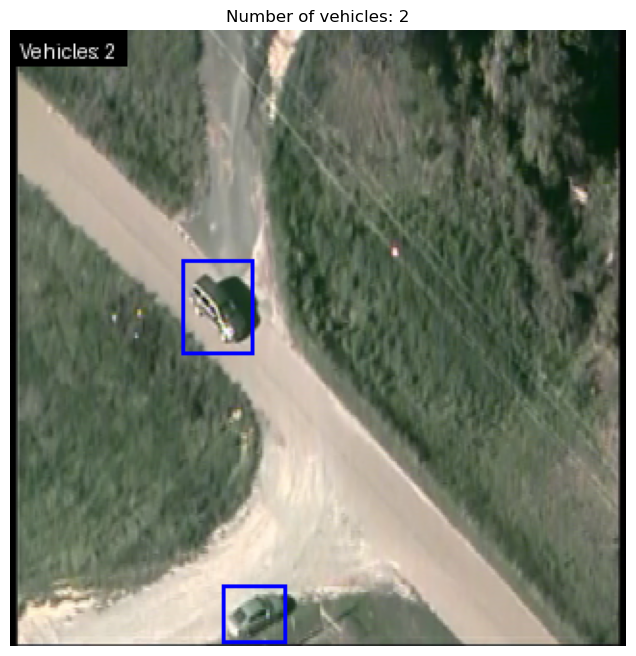

In [35]:
# Load and preprocess an example image for inference
random_image_file = pick_random_image(img_dir)
print(f"Randomly selected image: {random_image_file}")

image_path = os.path.join(img_dir, random_image_file)
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Perform inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Extract bounding boxes from the model output
output_boxes = output[0].cpu().numpy()  # Detach and move to CPU

# Get labels for the current image
image_labels = dataset.annotations[dataset.annotations['file'] == random_image_file]

# Convert image to numpy array and get its size
image_array = np.array(image)
image_size = image.size  # Get image size as a tuple (width, height)

# Draw bounding boxes on the image
image_with_boxes, vehicle_count = draw_bounding_boxes(image_array, image_labels, image_size)

# Display the image with bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(image_with_boxes)
plt.title(f'Number of vehicles: {vehicle_count}')
plt.axis('off')
plt.show()
